In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import sys

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

RAW_DATA_DIRECTORY = '/scratch/users/yucli/cesm_data'

# Renamed variable names 
VAR_NAMES = ["icefrac", "icethick", "temp", "geopotential", "psl", "lw_flux", "sw_flux", "ua"]


In [101]:
# this data was normalized relative to pd.date_range("1850-01", "1979-12", freq="MS")
# and ALL ensemble members. 

start_prediction_months = pd.date_range("1851-01", "2013-12", freq="MS")

input_config_all = {
    "name": "all",
    
    "start_prediction_months": start_prediction_months,

    'icefrac': {
        'include': True, 'anom': True, 'land_mask': True, 'lag': 12, 'divide_by_stdev': False
    }, 
    'icethick': {
        'include': True, 'anom': True, 'land_mask': True, 'lag': 12, 'divide_by_stdev': False
    }, 
    'temp': {
        'include': True, 'anom': True, 'land_mask': True, 'lag': 12, 'divide_by_stdev': True
    }, 
    'geopotential': {
        'include': True, 'anom': True, 'land_mask': False, 'lag': 6, 'divide_by_stdev': True
    }, 
    'psl': {
        'include': True, 'anom': True, 'land_mask': False, 'lag': 6, 'divide_by_stdev': True
    }, 
    'lw_flux': {
        'include': True, 'anom': True, 'land_mask': False, 'lag': 3, 'divide_by_stdev': True
    }, 
    'sw_flux': {
        'include': True, 'anom': True, 'land_mask': False, 'lag': 3, 'divide_by_stdev': True
    }, 
    'ua': {
        'include': True, 'anom': True, 'land_mask': False, 'lag': 3, 'divide_by_stdev': True
    }, 
    'cosine_of_init_month': {
        'include': True
    }, 
    'sine_of_init_month': {
        'include': True
    }
}


def load_inputs_data_da_dict(input_config, normalization_scheme=None):
    # TODO: implement option for different normalization schemes 
    data_da_dict = {}

    for var in VAR_NAMES: 
        if not input_config[var]["include"]:
            continue

        if input_config[var]["divide_by_stdev"]:
            norm = "norm"
        else: 
            norm = "anom"

        ds = xr.open_dataset(f"{RAW_DATA_DIRECTORY}/normalized_inputs/{var}_{norm}.nc", chunks={"member_id": 1})

        data_da_dict[var] = ds[var]

    # Get the common ensemble member_ids 
    common_member_ids = set()
    for i,da in enumerate(data_da_dict.values()): 
        if i == 0: 
            common_member_ids = set(da.member_id.data)
        else:
            common_member_ids = common_member_ids & set(da.member_id.data)

    for var, da in data_da_dict.items():
        da = da.sel(member_id = list(common_member_ids))
        
        # drop this auxiliary variable that is leftover from normalization 
        da = da.drop_vars("month")
        data_da_dict[var] = da

    return data_da_dict



In [107]:
data_da_dict = load_inputs_data_da_dict(input_config_all)

In [39]:
test_da = data_da_dict["icefrac"].isel(member_id=0, time=slice(0,12))

test_da = test_da.assign_coords(time=[f"icefrac_lag{13 - i}" for i in range(1,13)]).rename({"time": "channel"})

test_da.assign_coords(init_month = "2")

<xarray.DataArray 'icefrac' (channel: 12, y: 80, x: 80)> Size: 307kB
dask.array<getitem, shape=(12, 80, 80), dtype=float32, chunksize=(12, 80, 80), chunktype=numpy.ndarray>
Coordinates:
    member_id   <U12 48B 'r2i1231p1f1'
  * x           (x) float64 640B -4.208e+06 -4.101e+06 ... 4.101e+06 4.208e+06
  * y           (y) float64 640B -4.208e+06 -4.101e+06 ... 4.101e+06 4.208e+06
  * channel     (channel) <U13 624B 'icefrac_lag12' ... 'icefrac_lag1'
    init_month  <U1 4B '2'

In [103]:
def save_inputs_files(input_config, save_path):
    data_da_dict = load_inputs_data_da_dict(input_config)

    # save each ensemble member separately so the files don't get too big 
    member_ids = data_da_dict["icefrac"].member_id.data
    for member_id in member_ids:
        save_name = os.path.join(save_path, f"inputs_member_{member_id}.nc")
        if os.path.exists(save_name):
            continue

        print(f"Concatenating data into model input format for member {member_id}...")
        start_time = time.time()
        member_da_list = [] # we will concat this later 

        for start_prediction_month in input_config["start_prediction_months"]:

            time_da_list = []
            for input_var in VAR_NAMES:
                input_var_params = input_config[input_var]
                if not input_var_params["include"]: 
                    continue 

                prediction_input_months = pd.date_range(start_prediction_month - pd.DateOffset(months=input_var_params["lag"]), 
                                                        start_prediction_month - pd.DateOffset(months=1), freq="MS")

                input_data = data_da_dict[input_var].sel(time=prediction_input_months, member_id=member_id)

                # rename the time coordinate to channel 
                lag = input_var_params["lag"]
                input_data = input_data.assign_coords(time=[f"{input_var}_lag{lag+1-i}" for i in range(1, lag+1)])
                input_data = input_data.rename({"time": "channel"})

                # add a coordinate to denote the start prediction month (time origin)
                input_data = input_data.assign_coords(start_prediction_month=start_prediction_month)

                time_da_list.append(input_data)
            
            time_da_merged = xr.concat(time_da_list, dim="channel", coords='minimal', compat='override')
            member_da_list.append(time_da_merged)
        
        da_merged = xr.concat(member_da_list, dim="start_prediction_month", coords="minimal", compat='override')

        # rechunk
        da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "channel":48})
        
        print("done! Saving...")
        da_merged.to_dataset(name="data").to_netcdf(save_name)

        end_time = time.time()
        print(f"done! Elapsed time: {start_time - end_time:02f}")


da_merged = save_inputs_files(input_config_all, None)

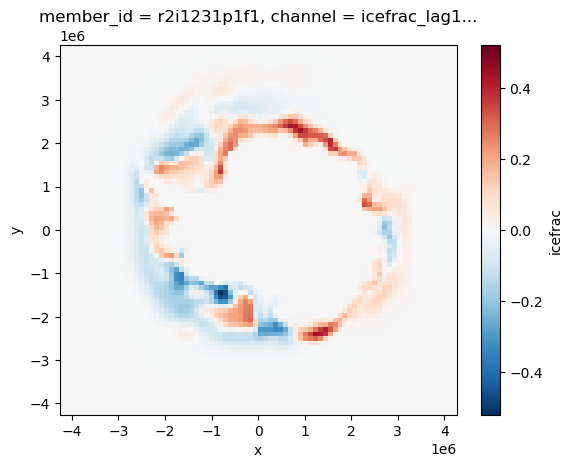

In [106]:
da_merged.isel(start_prediction_month=0, channel=0).plot()

In [ ]:
def save_inputs_file(input_config_name, input_config, inputs_save_path, start_prediction_months, 
                    clip_PDF_tails=True, clip_constant=6, verbose=1):

    # Retrieve land mask 
    land_mask = xr.open_dataset(f"{config.DATA_DIRECTORY}/NSIDC/land_mask.nc").mask.values
    land_mask = land_mask[np.newaxis, :, :]

    data_da_dict = load_inputs_data_da_dict(input_config)
    
    all_inputs = []
    for start_prediction_month in start_prediction_months:
        if verbose >= 2: print(f"Concatenating inputs for init month {start_prediction_month}")
        prediction_target_months = pd.date_range(start_prediction_month, \
            start_prediction_month + pd.DateOffset(months=config.max_month_lead_time-1), freq="MS")
        
        # For each target, generate data pairs
        input_list = []
        for input_var, input_var_params in input_config.items():
            if not input_var_params["include"]: 
                continue 

            if input_var == 'siconc_linear_forecast':
                input_data_npy = data_da_dict[input_var].sel(time=prediction_target_months).data
                
            elif input_var == 'cosine_of_init_month':
                input_data_npy = np.ones((1, 332, 316))
                input_data_npy *= np.cos(2 * np.pi * start_prediction_month.month / 12)

            elif input_var == 'sine_of_init_month':
                input_data_npy = np.ones((1, 332, 316))
                input_data_npy *= np.sin(2 * np.pi * start_prediction_month.month / 12)

            else:
                prediction_input_months = pd.date_range(start_prediction_month - pd.DateOffset(months=input_var_params["lag"]), \
                    start_prediction_month - pd.DateOffset(months=1), freq="MS")
                input_data_npy = data_da_dict[input_var].sel(time=prediction_input_months).data

                # to prevent super out-of-distribution SST and ssr data points
                if input_var in ["sea_surface_temperature", "surface_net_solar_radiation"]:
                    if clip_PDF_tails: 
                        input_data_npy = np.where(input_data_npy > clip_constant, clip_constant, input_data_npy)
                        input_data_npy = np.where(input_data_npy < -clip_constant, -clip_constant, input_data_npy)
            
            # Apply land mask. Land values go to 0 
            if input_var_params['land_mask']:
                land_mask_broadcast = np.repeat(land_mask, input_data_npy.shape[0], axis=0)
                input_data_npy[land_mask_broadcast] = 0

            input_list.append(input_data_npy)
        
        input_all_vars_npy = np.concatenate(input_list, axis=0)

        # add a new axis at the beginning for n_samples
        input_all_vars_npy = input_all_vars_npy[np.newaxis,:,:,:]
        all_inputs.append(input_all_vars_npy)

    all_inputs = np.concatenate(all_inputs, axis=0)

    print(f"Saving to {inputs_save_path}")
    write_hdf5_file(all_inputs, inputs_save_path, f"inputs_{input_config_name}")


In [6]:
class SeaIceDataset(torch.utils.data.Dataset):
    def __init__(self, data_directory, configuration, split_array, start_prediction_months, \
                split_type='train', target_shape=(80, 80), mode="regression", class_splits=None):
        self.data_directory = data_directory
        self.configuration = configuration
        self.split_array = split_array
        self.start_prediction_months = start_prediction_months
        self.split_type = split_type
        self.target_shape = target_shape
        self.class_splits = class_splits
        self.mode = mode

        # Open the HDF5 files
        self.inputs_file = h5py.File(f"{data_directory}/inputs_{configuration}.h5", 'r')

        if "sicanom" in configuration: 
            targets_configuration = "anom_regression" 
        else: 
            targets_configuration = "regression"

        self.targets_file = h5py.File(f"{data_directory}/targets_{targets_configuration}.h5", 'r')
        
        self.inputs = self.inputs_file[f"inputs_{configuration}"]
        self.targets = self.targets_file['targets_sea_ice_only']

        self.n_samples, self.n_channels, self.n_y, self.n_x = self.inputs.shape
        
        # Get indices for the specified split type
        self.indices = np.where(self.split_array == split_type)[0]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        input_data = self.inputs[actual_idx]
        target_data = self.targets[actual_idx]
        start_prediction_month = self.start_prediction_months[actual_idx]

        # Pad input_data and target_data to the target shape
        pad_y = self.target_shape[0] - self.n_y
        pad_x = self.target_shape[1] - self.n_x
        input_data = np.pad(input_data, ((0, 0), (pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)
        target_data = np.pad(target_data, ((0, 0), (pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)

        # If we are doing classification, then discretise the target data
        if self.mode == "classification":
            if self.class_splits is None:
                raise ValueError("need to specify a monotonically increasing list class_splits denoting class boundaries")

            # check if class_split is monotonically increasing
            if len(self.class_splits) > 1 and np.any(np.diff(self.class_splits) < 0): 
                raise ValueError("class_splits needs to be monotonically increasing")

            bounds = [] # bounds for classes
            for i,class_split in enumerate(self.class_splits): 
                if i == 0: 
                    bounds.append([0, class_split])
                if i == len(self.class_splits) - 1: 
                    bounds.append([class_split, 1])
                else: 
                    bounds.append([class_split, self.class_splits[i+1]])
            
            target_classes_data = np.zeros_like(target_data) 
            target_classes_data = target_classes_data[np.newaxis,:,:,:]
            target_classes_data = np.repeat(target_classes_data, len(bounds), axis=0)
            for i,bound in enumerate(bounds): 
                if i == len(bounds) - 1: 
                    target_classes_data[i,:,:,:] = np.logical_and(target_data >= bound[0], target_data <= bound[1]).astype(int)
                else:
                    target_classes_data[i,:,:,:] = np.logical_and(target_data >= bound[0], target_data < bound[1]).astype(int)
            
            target_data = target_classes_data 

        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        target_tensor = torch.tensor(target_data, dtype=torch.float32)

        # Get the target months for this sample
        target_months = pd.date_range(start=start_prediction_month, end=start_prediction_month + pd.DateOffset(months=5), freq="MS")
        target_months = target_months.month.to_numpy()
        
        return input_tensor, target_tensor, target_months

    def __del__(self):
        self.inputs_file.close()
        self.targets_file.close()


